# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
from tqdm.notebook import tqdm
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-12 13:01:57.591404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741784517.604663   69372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741784517.608476   69372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741784517.619306   69372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741784517.619318   69372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741784517.619319   69372 computation_placer.cc:177] computation placer alr

In [2]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [3]:
from utils.visualization_funcs import plot_random_images_bbox

In [4]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [5]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [6]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [7]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)


IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(CLASS_NAME)


## Dataset Download from Roboflow

In [8]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("tensorflow")      

## Load images from directory

In [9]:
from utils.prepare_dataset import AnnotationProcessor

prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(100, 100, 100)

In [10]:
train_bboxes[0]

array([[0.57916667, 0.33333333, 0.75833333, 0.425     ],
       [0.5375    , 0.275     , 0.82916667, 0.5125    ],
       [0.57083333, 0.32083333, 0.76666667, 0.45416667]])

## Rebalance dataset by Down sempling to dataset with min images

In [11]:
# rebal_train_images, rebal_train_class_ids, rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets(augment=False)
# len(train_images), len(train_class_ids), len(train_bboxes)

In [12]:
train_class_ids[1]

[1]

In [13]:
def pad_cls_id_bbx(class_id_list, bbox_list):
    padded_class_ids = tf.keras.preprocessing.sequence.pad_sequences(
    class_id_list, padding='post', dtype='int32')
    padded_bbx = tf.keras.preprocessing.sequence.pad_sequences(
        bbox_list, padding='post', dtype='float32')
    
    return padded_class_ids, padded_bbx

In [14]:
padded_class_ids, padded_bbx = pad_cls_id_bbx(train_class_ids, train_bboxes)
padded_bbx[1], len(padded_bbx)

(array([[0.5208333 , 0.51666665, 0.6791667 , 0.6125    ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 100)

In [15]:
padded_class_ids[1], len(padded_class_ids)

(array([1, 0, 0], dtype=int32), 100)

In [16]:
train_datasets = tf.data.Dataset.from_tensor_slices(
    (train_images, padded_class_ids, padded_bbx))
del train_images, train_class_ids, train_bboxes, padded_class_ids, padded_bbx
len(train_datasets)

I0000 00:00:1741784521.075345   69372 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6938 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


100

In [17]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image, class_ids, bbox):
    tf_image = load_image(image)
    multi_hot = tf.reduce_sum(
    tf.one_hot(class_ids, NUM_CLASSES), 
    axis=0
)  # Shape: (NUM_CLASSES,)
    return  tf_image, multi_hot, bbox

def preprocess(image_batch, class_ids, bbox):
    processed_image_batch = tf.keras.applications.resnet.preprocess_input(image_batch)
    return processed_image_batch, (class_ids, bbox)

### Augmentation 

In [18]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomSaturation(0.1),
    layers.RandomHue(0.1)
])

In [19]:
train_ds = train_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE) 
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x,y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
for batch in train_ds.take(1):
    image, (class_id, bbx) = batch
    print(image.shape, class_id, bbx.shape)
    print(image.dtype, class_id.dtype, bbx.dtype)

(240, 240, 3) tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32) (3, 4)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>


2025-03-12 13:02:01.646973: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
train_ds = train_ds.shuffle(buffer_size=train_datasets.cardinality().numpy(), reshuffle_each_iteration=True)\
                                .batch(BATCH_SIZE)\
                                .prefetch(tf.data.AUTOTUNE)

In [22]:
for batch in train_ds.take(1):
    image, (class_id, bbx) = batch
    print(image.numpy().min(), image.numpy().max())

0.0 255.0


2025-03-12 13:02:02.531290: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [23]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))

valid_image_paths, valid_class_ids, valid_bboxes  = prepare_train_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(100, 100, 100)

In [24]:
valid_padded_class_ids, valid_padded_bbx = pad_cls_id_bbx(valid_class_ids, valid_bboxes)

In [25]:
val_datasets = tf.data.Dataset.from_tensor_slices((valid_image_paths,
                                               valid_padded_class_ids,
                                               valid_padded_bbx))

valid_ds = val_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                .batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [26]:
for batch in valid_ds.take(1):
    image, (cls, bbx) = batch
    print(bbx.shape)

(16, 3, 4)


## Define ResNet50 Model

In [27]:
import keras
input_shape = (IMG_SIZE, IMG_SIZE, 3)
### Define ResNet50 as a Feature Extractor
def feature_extractor(inputs)-> tf.keras.Model:
    resnet50 = tf.keras.applications.ResNet50(
        include_top = False, 
        weights = "imagenet",
        input_shape = input_shape,    
        input_tensor=inputs
    )
    resnet50.trainable = True
    for layer in resnet50.layers[:140]: #example number of layers to freeze
        layer.trainable = False
    feature_extractor = resnet50.output
    return feature_extractor


### Define Dense Layers
def dense_layers(features)->tf.keras.Layer:
    x = keras.layers.Conv2D(filters=256, kernel_size=(1, 1), activation='relu')(features) # 1x1 conv
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=1024, activation='relu', kernel_regularizer='l2')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=512, activation='relu', kernel_regularizer='l2')(x)
    return x

### Define Bounding Box Regression
def bounding_box_regression(x)->tf.keras.Layer:
    bbox_shape=4
    bounding_box_regression_output = tf.keras.layers.Dense(units=bbox_shape*NUM_CLASSES, name='_bounding_box', activation='linear')(x)
    reshape_bbox = tf.keras.layers.Reshape(
        (NUM_CLASSES, 4),  # Not hard-coded
        name='bounding_box'
    )(bounding_box_regression_output)
    return reshape_bbox

###Define Classifier Layer
def classifer(inputs)->tf.keras.Model:
    return tf.keras.layers.Dense(units=NUM_CLASSES, activation='sigmoid', name = 'classification')(inputs)

def final_model()->tf.keras.Model:
    
    inputs = tf.keras.layers.Input(shape=input_shape)

    _feature_extractor = feature_extractor(inputs)
   
    dense_output = dense_layers(_feature_extractor)

    bounding_box_regression_output = bounding_box_regression(dense_output)

    classification_output = classifer(dense_output)

    return tf.keras.Model(inputs=inputs, 
                          outputs=[classification_output, 
                                   bounding_box_regression_output])

In [28]:
def mobv2_feature_extractor(inputs):
    
    inputs = tf.keras.applications.mobilenet.preprocess_input(inputs)

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)

    # return the feature_extractor
    return feature_extractor#.outputs

### Final Model

In [29]:
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC', multi_label=True), 
    tf.keras.metrics.F1Score(name='f1_score',average='weighted'),
]

### Learning Rate Tuning


### Define  Callbacks

In [30]:
import os

to_monitor = 'val_loss'
mode = 'min'
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=2, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-6,
                                            verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "ckpt_{epoch}.keras") ,
                                        save_weights_only=False,
                                        save_best_only=True,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
                                        
    tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=10,
                                    mode=mode, 
                                    restore_best_weights=True),

]

### Define Optimizer

In [31]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, use_ema=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, clipvalue=1.0)

# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, clipvalue=1.0)
optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN.LEARNING_RATE)

## Model Building and Compilation

In [32]:
import tensorflow as tf

def iou_loss(y_true, y_pred):  # Assuming y_true and y_pred are (batch_size, 4)
    # y_true = y_true[0]
    # y_pred = tf.reshape(y_pred, ( 3, 4))
    y_true = tf.cast(y_true, dtype=tf.float32) # Cast to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32) # Cast to float32

    x_true = y_true[..., 0]
    y_true_ = y_true[..., 1]
    x_max_true = y_true[..., 2]
    y_max_true = y_true[..., 3]

    x_pred = y_pred[..., 0]
    y_pred_ = y_pred[..., 1]
    x_max_pred = y_pred[..., 2]
    y_max_pred = y_pred[..., 3]

    area_true = (x_max_true - x_true) * (y_max_true - y_true_)
    area_pred = (x_max_pred - x_pred) * (y_max_pred - y_pred_)

    x_intersect = tf.maximum(x_true, x_pred)
    y_intersect = tf.maximum(y_true_, y_pred_)
    x_max_intersect = tf.minimum(x_max_true, x_max_pred)
    y_max_intersect = tf.minimum(y_max_true, y_max_pred)

    area_intersect = tf.maximum(0.0, x_max_intersect - x_intersect) * tf.maximum(0.0, y_max_intersect - y_intersect) # avoid negative values
    iou = area_intersect / (area_true + area_pred - area_intersect + 1e-7)  # Add small epsilon for numerical stability
    return 1.0 - iou  # We want to *minimize* the loss

def iou_metric(y_true, y_pred):  # No negation for metric
    # y_true = y_true[0]
    # y_pred = tf.reshape(y_pred, (3, 4))
    y_true = tf.cast(y_true, dtype=tf.float32) # Cast to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32) # Cast to float32

    x_true = y_true[..., 0]
    y_true_ = y_true[..., 1]
    x_max_true = y_true[..., 2]
    y_max_true = y_true[..., 3]

    x_pred = y_pred[..., 0]
    y_pred_ = y_pred[..., 1]
    x_max_pred = y_pred[..., 2]
    y_max_pred = y_pred[..., 3]

    area_true = (x_max_true - x_true) * (y_max_true - y_true_)
    area_pred = (x_max_pred - x_pred) * (y_max_pred - y_pred_)

    x_intersect = tf.maximum(x_true, x_pred)
    y_intersect = tf.maximum(y_true_, y_pred_)
    x_max_intersect = tf.minimum(x_max_true, x_max_pred)
    y_max_intersect = tf.minimum(y_max_true, y_max_pred)

    area_intersect = tf.maximum(0.0, x_max_intersect - x_intersect) * tf.maximum(0.0, y_max_intersect - y_intersect) # avoid negative values
    iou = area_intersect / (area_true + area_pred - area_intersect + 1e-7)  # Add small epsilon for numerical stability
    return iou  # Return IoU directly for metric

def bounding_box_loss(y_true, y_pred):
    # Reshape the output to (batch_size, 3, 4)
    y_pred = tf.reshape(y_pred, (-1, 3, 4))
    #y_true should be of shape (batch_size, 3, 4)
    loss = 0
    for tr_bb, pr_bb in zip(y_true, y_pred):
        loss += tf.keras.losses.MeanSquaredError()(tr_bb[0, :], pr_bb[0,:])
    return loss

In [33]:
tf.keras.backend.clear_session()

model = final_model()
# model.compile(
#     optimizer=optimizer,
#     loss={'classification': 'binary_crossentropy', 'bounding_box': iou_loss},
#     metrics={'classification': METRICS, 'bounding_box': iou_metric})  # Use IoU metric
model.compile(
    optimizer=optimizer,
    loss={'classification': 'binary_crossentropy', 'bounding_box': 'mse'},
    metrics={'classification': METRICS, 'bounding_box': 'mse'})  # Use IoU metric


In [34]:
# model.summary()

### Train and Validate the model

In [35]:
EPOCHS = 50

In [36]:
import mlflow

mlflow.set_experiment("/brain-tumor-resnet50")
mlflow.tensorflow.autolog(log_models=True, log_datasets=False)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks],
)

2025/03/12 13:02:05 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
2025/03/12 13:02:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '05650f7daa4c44c39081b84b01d4bdb9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50


I0000 00:00:1741784533.062166   69494 service.cc:152] XLA service 0x71760c003ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741784533.062184   69494 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-12 13:02:13.331600: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741784534.673749   69494 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-12 13:02:15.807652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 48 bytes spill stores, 48 bytes spill loads

2025-03-12 13:02:16.066180: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 264 byte

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - bounding_box_loss: 0.2429 - bounding_box_mse: 0.2429 - classification_AUC: 0.1141 - classification_f1_score: 0.4990 - classification_loss: 0.6675 - classification_precision: 0.8400 - classification_recall: 0.5433 - loss: 11.8400 

I0000 00:00:1741784541.901596   69494 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - bounding_box_loss: 0.2412 - bounding_box_mse: 0.2412 - classification_AUC: 0.1335 - classification_f1_score: 0.5057 - classification_loss: 0.6588 - classification_precision: 0.8440 - classification_recall: 0.5710 - loss: 11.8122

2025-03-12 13:02:24.286630: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7395', 8 bytes spill stores, 8 bytes spill loads

2025-03-12 13:02:24.743360: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8554', 48 bytes spill stores, 48 bytes spill loads

2025-03-12 13:02:25.022270: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 256 bytes spill stores, 256 bytes spill loads

2025-03-12 13:02:25.147685: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 124 bytes spill stores, 124 bytes spill loads

2025-03-12 13:02:25.414251: I external/local_xla

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - bounding_box_loss: 0.2374 - bounding_box_mse: 0.2368 - classification_AUC: 0.1566 - classification_f1_score: 0.5190 - classification_loss: 0.6477 - classification_precision: 0.8548 - classification_recall: 0.6019 - loss: 11.7828  

2025-03-12 13:02:32.122961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1819_0', 208 bytes spill stores, 400 bytes spill loads

2025-03-12 13:02:32.164290: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1819', 40 bytes spill stores, 84 bytes spill loads

2025-03-12 13:02:32.203832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1819', 80 bytes spill stores, 144 bytes spill loads

2025-03-12 13:02:32.262230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1819', 608 bytes spill stores, 608 bytes spill loads

2025-03-12 13:02:35.031161: I ext


Epoch 1: val_loss improved from inf to 11.34957, saving model to output/checkpoints/ckpt_1.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - bounding_box_loss: 0.2366 - bounding_box_mse: 0.2356 - classification_AUC: 0.1647 - classification_f1_score: 0.5232 - classification_loss: 0.6434 - classification_precision: 0.8586 - classification_recall: 0.6124 - loss: 11.7731 - val_bounding_box_loss: 0.1976 - val_bounding_box_mse: 0.1970 - val_classification_AUC: 0.1680 - val_classification_f1_score: 0.5280 - val_classification_loss: 0.4395 - val_classification_precision: 0.8741 - val_classification_recall: 0.9772 - val_loss: 11.3496 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - bounding_box_loss: 0.1745 - bounding_box_mse: 0.1736 - classification_AUC: 0.3699 - classification_f1_score: 0.6267 - classification_loss: 0.4900 - classification_precision: 0.9087 - classification_recall: 0.8934 - loss: 11.3250
Epoch 2: val_loss improved from 11.34957 to 10.87888, saving model to output/checkpoints/ckpt_2.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - bounding_box_loss: 0.1750 - bounding_box_mse: 0.1735 - classification_AUC: 0.3863 - classification_f1_score: 0.6241 - classification_loss: 0.4878 - classification_precision: 0.9094 - classification_recall: 0.8961 - loss: 11.3176 - val_bounding_box_loss: 0.1547 - val_bounding_box_mse: 0.1549 - val_classification_AUC: 0.1963 - val_classification_f1_score: 0.5280 - val_classification_loss: 0.2279 - val_classification_precision: 0.8767 - val_classification_recall: 1.0000 - val_loss: 10.8789 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - bounding_box_loss: 0.1403 - bounding_box_mse: 0.1411 - classification_AUC: 0.3183 - classification_f1_score: 0.5440 - classification_loss: 0.3201 - classification_precision: 0.9267 - classification_recall: 0.9638 - loss: 10.9004
Epoch 3: val_loss improved from 10.87888 to 10.50918, saving model to output/checkpoints/ckpt_3.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - bounding_box_loss: 0.1384 - bounding_box_mse: 0.1397 - classification_AUC: 0.3370 - classification_f1_score: 0.5461 - classification_loss: 0.3150 - classification_precision: 0.9253 - classification_recall: 0.9635 - loss: 10.8902 - val_bounding_box_loss: 0.1338 - val_bounding_box_mse: 0.1336 - val_classification_AUC: 0.2052 - val_classification_f1_score: 0.5280 - val_classification_loss: 0.0915 - val_classification_precision: 0.8796 - val_classification_recall: 1.0000 - val_loss: 10.5092 - learning_rate: 1.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 0.1291 - bounding_box_mse: 0.1291 - classification_AUC: 0.3017 - classification_f1_score: 0.5848 - classification_loss: 0.0836 - classification_precision: 0.8950 - classification_recall: 0.9680 - loss: 10.4368
Epoch 4: val_loss improved from 10.50918 to 10.16634, saving model to output/checkpoints/ckpt_4.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - bounding_box_loss: 0.1265 - bounding_box_mse: 0.1266 - classification_AUC: 0.3275 - classification_f1_score: 0.5811 - classification_loss: 0.0835 - classification_precision: 0.8967 - classification_recall: 0.9672 - loss: 10.4297 - val_bounding_box_loss: 0.1170 - val_bounding_box_mse: 0.1165 - val_classification_AUC: 0.2184 - val_classification_f1_score: 0.5280 - val_classification_loss: -0.0315 - val_classification_precision: 0.8855 - val_classification_recall: 1.0000 - val_loss: 10.1663 - learning_rate: 1.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - bounding_box_loss: 0.1047 - bounding_box_mse: 0.1047 - classification_AUC: 0.4431 - classification_f1_score: 0.5666 - classification_loss: -0.1140 - classification_precision: 0.9056 - classification_recall: 0.9556 - loss: 10.0113
Epoch 5: val_loss improved from 10.16634 to 9.87201, saving model to output/checkpoints/ckpt_5.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - bounding_box_loss: 0.1054 - bounding_box_mse: 0.1054 - classification_AUC: 0.4486 - classification_f1_score: 0.5652 - classification_loss: -0.1173 - classification_precision: 0.9057 - classification_recall: 0.9573 - loss: 10.0042 - val_bounding_box_loss: 0.1090 - val_bounding_box_mse: 0.1075 - val_classification_AUC: 0.2224 - val_classification_f1_score: 0.5280 - val_classification_loss: -0.1253 - val_classification_precision: 0.8885 - val_classification_recall: 1.0000 - val_loss: 9.8720 - learning_rate: 1.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 0.1215 - bounding_box_mse: 0.1218 - classification_AUC: 0.4263 - classification_f1_score: 0.5722 - classification_loss: -0.3685 - classification_precision: 0.8774 - classification_recall: 0.9768 - loss: 9.5806
Epoch 6: val_loss improved from 9.87201 to 9.59485, saving model to output/checkpoints/ckpt_6.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - bounding_box_loss: 0.1209 - bounding_box_mse: 0.1216 - classification_AUC: 0.4416 - classification_f1_score: 0.5701 - classification_loss: -0.3723 - classification_precision: 0.8798 - classification_recall: 0.9768 - loss: 9.5727 - val_bounding_box_loss: 0.1178 - val_bounding_box_mse: 0.1159 - val_classification_AUC: 0.2217 - val_classification_f1_score: 0.5280 - val_classification_loss: -0.2221 - val_classification_precision: 0.9149 - val_classification_recall: 0.9810 - val_loss: 9.5948 - learning_rate: 1.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - bounding_box_loss: 0.1239 - bounding_box_mse: 0.1243 - classification_AUC: 0.3187 - classification_f1_score: 0.5678 - classification_loss: -0.6691 - classification_precision: 0.9103 - classification_recall: 0.9938 - loss: 9.0855
Epoch 7: val_loss improved from 9.59485 to 9.11870, saving model to output/checkpoints/ckpt_7.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - bounding_box_loss: 0.1237 - bounding_box_mse: 0.1245 - classification_AUC: 0.3369 - classification_f1_score: 0.5662 - classification_loss: -0.6573 - classification_precision: 0.9107 - classification_recall: 0.9926 - loss: 9.0834 - val_bounding_box_loss: 0.1343 - val_bounding_box_mse: 0.1331 - val_classification_AUC: 0.2257 - val_classification_f1_score: 0.5280 - val_classification_loss: -0.5240 - val_classification_precision: 0.9206 - val_classification_recall: 0.9696 - val_loss: 9.1187 - learning_rate: 1.0000e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 0.1587 - bounding_box_mse: 0.1592 - classification_AUC: 0.5407 - classification_f1_score: 0.5702 - classification_loss: -1.0251 - classification_precision: 0.8853 - classification_recall: 0.9731 - loss: 8.6039
Epoch 8: val_loss improved from 9.11870 to 8.91620, saving model to output/checkpoints/ckpt_8.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - bounding_box_loss: 0.1579 - bounding_box_mse: 0.1588 - classification_AUC: 0.5437 - classification_f1_score: 0.5683 - classification_loss: -1.0316 - classification_precision: 0.8863 - classification_recall: 0.9735 - loss: 8.5915 - val_bounding_box_loss: 0.1312 - val_bounding_box_mse: 0.1297 - val_classification_AUC: 0.2298 - val_classification_f1_score: 0.5280 - val_classification_loss: -0.5676 - val_classification_precision: 0.9206 - val_classification_recall: 0.9696 - val_loss: 8.9162 - learning_rate: 1.0000e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 0.1710 - bounding_box_mse: 0.1708 - classification_AUC: 0.3770 - classification_f1_score: 0.5594 - classification_loss: -1.4704 - classification_precision: 0.9075 - classification_recall: 0.9757 - loss: 8.0285
Epoch 9: val_loss improved from 8.91620 to 8.58426, saving model to output/checkpoints/ckpt_9.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - bounding_box_loss: 0.1722 - bounding_box_mse: 0.1719 - classification_AUC: 0.3800 - classification_f1_score: 0.5589 - classification_loss: -1.4948 - classification_precision: 0.9082 - classification_recall: 0.9758 - loss: 8.0127 - val_bounding_box_loss: 0.1327 - val_bounding_box_mse: 0.1305 - val_classification_AUC: 0.2302 - val_classification_f1_score: 0.5280 - val_classification_loss: -0.7671 - val_classification_precision: 0.9170 - val_classification_recall: 0.9658 - val_loss: 8.5843 - learning_rate: 1.0000e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 0.1875 - bounding_box_mse: 0.1878 - classification_AUC: 0.3395 - classification_f1_score: 0.5622 - classification_loss: -2.2020 - classification_precision: 0.9350 - classification_recall: 0.9848 - loss: 7.1381
Epoch 10: val_loss improved from 8.58426 to 7.78649, saving model to output/checkpoints/ckpt_10.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - bounding_box_loss: 0.1878 - bounding_box_mse: 0.1884 - classification_AUC: 0.3469 - classification_f1_score: 0.5613 - classification_loss: -2.1907 - classification_precision: 0.9352 - classification_recall: 0.9842 - loss: 7.1336 - val_bounding_box_loss: 0.1483 - val_bounding_box_mse: 0.1463 - val_classification_AUC: 0.2365 - val_classification_f1_score: 0.5280 - val_classification_loss: -1.4088 - val_classification_precision: 0.9328 - val_classification_recall: 0.9506 - val_loss: 7.7865 - learning_rate: 1.0000e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - bounding_box_loss: 0.2109 - bounding_box_mse: 0.2108 - classification_AUC: 0.3698 - classification_f1_score: 0.5516 - classification_loss: -2.6162 - classification_precision: 0.9585 - classification_recall: 0.9782 - loss: 6.6651
Epoch 11: val_loss improved from 7.78649 to 7.52385, saving model to output/checkpoints/ckpt_11.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - bounding_box_loss: 0.2128 - bounding_box_mse: 0.2126 - classification_AUC: 0.3926 - classification_f1_score: 0.5520 - classification_loss: -2.6614 - classification_precision: 0.9567 - classification_recall: 0.9775 - loss: 6.6392 - val_bounding_box_loss: 0.1556 - val_bounding_box_mse: 0.1542 - val_classification_AUC: 0.2424 - val_classification_f1_score: 0.5280 - val_classification_loss: -1.6662 - val_classification_precision: 0.9639 - val_classification_recall: 0.9125 - val_loss: 7.5238 - learning_rate: 1.0000e-04
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - bounding_box_loss: 0.2498 - bounding_box_mse: 0.2500 - classification_AUC: 0.3695 - classification_f1_score: 0.5566 - classification_loss: -4.0502 - classification_precision: 0.9414 - classification_recall: 0.9944 - loss: 5.0597
Epoch 12: val_loss improved from 7.52385 to 7.07566, saving model to output/checkpoints/ckpt_12.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - bounding_box_loss: 0.2518 - bounding_box_mse: 0.2522 - classification_AUC: 0.3696 - classification_f1_score: 0.5565 - classification_loss: -4.0121 - classification_precision: 0.9413 - classification_recall: 0.9931 - loss: 5.0446 - val_bounding_box_loss: 0.1266 - val_bounding_box_mse: 0.1250 - val_classification_AUC: 0.2350 - val_classification_f1_score: 0.5280 - val_classification_loss: -1.8930 - val_classification_precision: 0.9228 - val_classification_recall: 0.9544 - val_loss: 7.0757 - learning_rate: 1.0000e-04
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 0.3868 - bounding_box_mse: 0.3903 - classification_AUC: 0.3849 - classification_f1_score: 0.5548 - classification_loss: -5.8884 - classification_precision: 0.9716 - classification_recall: 0.9935 - loss: 3.2737
Epoch 13: val_loss improved from 7.07566 to 6.00939, saving model to output/checkpoints/ckpt_13.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - bounding_box_loss: 0.3806 - bounding_box_mse: 0.3867 - classification_AUC: 0.3879 - classification_f1_score: 0.5549 - classification_loss: -5.8718 - classification_precision: 0.9718 - classification_recall: 0.9933 - loss: 3.2389 - val_bounding_box_loss: 0.1498 - val_bounding_box_mse: 0.1496 - val_classification_AUC: 0.2232 - val_classification_f1_score: 0.5410 - val_classification_loss: -2.8352 - val_classification_precision: 0.9354 - val_classification_recall: 0.9354 - val_loss: 6.0094 - learning_rate: 1.0000e-04
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 0.5291 - bounding_box_mse: 0.5258 - classification_AUC: 0.3917 - classification_f1_score: 0.6122 - classification_loss: -8.0260 - classification_precision: 0.9465 - classification_recall: 0.9943 - loss: 1.3089
Epoch 14: val_loss improved from 6.00939 to 5.24223, saving model to output/checkpoints/ckpt_14.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - bounding_box_loss: 0.5341 - bounding_box_mse: 0.5284 - classification_AUC: 0.3932 - classification_f1_score: 0.6098 - classification_loss: -8.0710 - classification_precision: 0.9489 - classification_recall: 0.9941 - loss: 1.3089 - val_bounding_box_loss: 0.1395 - val_bounding_box_mse: 0.1419 - val_classification_AUC: 0.2287 - val_classification_f1_score: 0.5410 - val_classification_loss: -3.4497 - val_classification_precision: 0.9296 - val_classification_recall: 0.9544 - val_loss: 5.2422 - learning_rate: 1.0000e-04
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - bounding_box_loss: 0.6117 - bounding_box_mse: 0.6070 - classification_AUC: 0.3448 - classification_f1_score: 0.6387 - classification_loss: -10.9480 - classification_precision: 0.9849 - classification_recall: 0.9944 - loss: -1.6479
Epoch 15: val_loss improved from 5.24223 to 3.93164, saving model to output/checkpoints/ckpt_15.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - bounding_box_loss: 0.6195 - bounding_box_mse: 0.6114 - classification_AUC: 0.3509 - classification_f1_score: 0.6384 - classification_loss: -10.9616 - classification_precision: 0.9844 - classification_recall: 0.9946 - loss: -1.6504 - val_bounding_box_loss: 0.1328 - val_bounding_box_mse: 0.1333 - val_classification_AUC: 0.2234 - val_classification_f1_score: 0.5474 - val_classification_loss: -5.1448 - val_classification_precision: 0.9294 - val_classification_recall: 0.9506 - val_loss: 3.9316 - learning_rate: 1.0000e-04
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 0.8285 - bounding_box_mse: 0.8108 - classification_AUC: 0.3693 - classification_f1_score: 0.6235 - classification_loss: -13.2638 - classification_precision: 0.9914 - classification_recall: 0.9913 - loss: -3.7516
Epoch 16: val_loss improved from 3.93164 to 3.31691, saving model to output/checkpoints/ckpt_16.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - bounding_box_loss: 0.8511 - bounding_box_mse: 0.8202 - classification_AUC: 0.3731 - classification_f1_score: 0.6293 - classification_loss: -13.5665 - classification_precision: 0.9901 - classification_recall: 0.9919 - loss: -3.9915 - val_bounding_box_loss: 0.1311 - val_bounding_box_mse: 0.1329 - val_classification_AUC: 0.2253 - val_classification_f1_score: 0.5474 - val_classification_loss: -5.5603 - val_classification_precision: 0.9257 - val_classification_recall: 0.9468 - val_loss: 3.3169 - learning_rate: 1.0000e-04
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - bounding_box_loss: 1.1944 - bounding_box_mse: 1.1991 - classification_AUC: 0.3836 - classification_f1_score: 0.6614 - classification_loss: -18.2878 - classification_precision: 0.9944 - classification_recall: 0.9978 - loss: -8.8068
Epoch 17: val_loss did not improve from 3.31691
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - bounding_box_loss: 1.1807 - bounding_box_mse: 1.1889 - classificat

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - bounding_box_loss: 1.3334 - bounding_box_mse: 1.3383 - classification_AUC: 0.4216 - classification_f1_score: 0.7266 - classification_loss: -26.8165 - classification_precision: 0.9915 - classification_recall: 0.9985 - loss: -17.0308 - val_bounding_box_loss: 0.1579 - val_bounding_box_mse: 0.1598 - val_classification_AUC: 0.2026 - val_classification_f1_score: 0.5886 - val_classification_loss: -8.4289 - val_classification_precision: 0.9176 - val_classification_recall: 0.9734 - val_loss: 0.9536 - learning_rate: 1.0000e-04
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 2.0347 - bounding_box_mse: 2.0490 - classification_AUC: 0.3879 - classification_f1_score: 0.6937 - classification_loss: -28.1348 - classification_precision: 0.9929 - classification_recall: 0.9971 - loss: -18.0002
Epoch 19: val_loss improved from 0.95361 to -3.42542, saving model to output/checkpoints/ckpt_19.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - bounding_box_loss: 1.9906 - bounding_box_mse: 2.0156 - classification_AUC: 0.3933 - classification_f1_score: 0.6939 - classification_loss: -27.8214 - classification_precision: 0.9913 - classification_recall: 0.9960 - loss: -18.0626 - val_bounding_box_loss: 0.2404 - val_bounding_box_mse: 0.2493 - val_classification_AUC: 0.1978 - val_classification_f1_score: 0.6857 - val_classification_loss: -13.1754 - val_classification_precision: 0.9237 - val_classification_recall: 0.9202 - val_loss: -3.4254 - learning_rate: 1.0000e-04
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 2.2880 - bounding_box_mse: 2.3154 - classification_AUC: 0.3787 - classification_f1_score: 0.7396 - classification_loss: -36.2916 - classification_precision: 0.9982 - classification_recall: 0.9977 - loss: -25.7621
Epoch 20: val_loss improved from -3.42542 to -5.42343, saving model to output/checkpoints/ckpt_20.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - bounding_box_loss: 2.2451 - bounding_box_mse: 2.2930 - classification_AUC: 0.3859 - classification_f1_score: 0.7371 - classification_loss: -35.9517 - classification_precision: 0.9979 - classification_recall: 0.9971 - loss: -25.6819 - val_bounding_box_loss: 0.4417 - val_bounding_box_mse: 0.4488 - val_classification_AUC: 0.2006 - val_classification_f1_score: 0.6613 - val_classification_loss: -16.4758 - val_classification_precision: 0.9429 - val_classification_recall: 0.8783 - val_loss: -5.4234 - learning_rate: 1.0000e-04
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - bounding_box_loss: 2.2489 - bounding_box_mse: 2.2443 - classification_AUC: 0.3629 - classification_f1_score: 0.6647 - classification_loss: -34.5604 - classification_precision: 0.9907 - classification_recall: 0.9925 - loss: -23.8284
Epoch 21: val_loss improved from -5.42343 to -7.58545, saving model to output/checkpoints/ckpt_21.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - bounding_box_loss: 2.2620 - bounding_box_mse: 2.2540 - classification_AUC: 0.3733 - classification_f1_score: 0.6710 - classification_loss: -35.1277 - classification_precision: 0.9894 - classification_recall: 0.9925 - loss: -24.4142 - val_bounding_box_loss: 0.3084 - val_bounding_box_mse: 0.3152 - val_classification_AUC: 0.2239 - val_classification_f1_score: 0.6047 - val_classification_loss: -17.5789 - val_classification_precision: 0.9414 - val_classification_recall: 0.9163 - val_loss: -7.5854 - learning_rate: 1.0000e-04
Epoch 22/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.1952 - bounding_box_mse: 3.1710 - classification_AUC: 0.3934 - classification_f1_score: 0.7198 - classification_loss: -46.0095 - classification_precision: 0.9874 - classification_recall: 0.9912 - loss: -34.3264
Epoch 22: val_loss did not improve from -7.58545
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - bounding_box_loss: 3.2387 - bounding_box_mse: 3.1964 - classi

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - bounding_box_loss: 3.4843 - bounding_box_mse: 3.4819 - classification_AUC: 0.4753 - classification_f1_score: 0.7125 - classification_loss: -69.3142 - classification_precision: 0.9714 - classification_recall: 0.9933 - loss: -57.4098 - val_bounding_box_loss: 0.1175 - val_bounding_box_mse: 0.1208 - val_classification_AUC: 0.2052 - val_classification_f1_score: 0.6047 - val_classification_loss: -16.7313 - val_classification_precision: 0.9265 - val_classification_recall: 0.9582 - val_loss: -8.1236 - learning_rate: 1.0000e-06
Epoch 31/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - bounding_box_loss: 2.9089 - bounding_box_mse: 2.8990 - classification_AUC: 0.3638 - classification_f1_score: 0.6581 - classification_loss: -56.9740 - classification_precision: 0.9934 - classification_recall: 0.9744 - loss: -45.5071
Epoch 31: val_loss improved from -8.12360 to -8.41851, saving model to output/checkpoints/ckpt_31.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - bounding_box_loss: 2.9318 - bounding_box_mse: 2.9144 - classification_AUC: 0.3762 - classification_f1_score: 0.6680 - classification_loss: -58.0483 - classification_precision: 0.9918 - classification_recall: 0.9762 - loss: -46.5544 - val_bounding_box_loss: 0.1172 - val_bounding_box_mse: 0.1206 - val_classification_AUC: 0.2053 - val_classification_f1_score: 0.6047 - val_classification_loss: -17.0614 - val_classification_precision: 0.9299 - val_classification_recall: 0.9582 - val_loss: -8.4185 - learning_rate: 1.0000e-06
Epoch 32/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 3.5438 - bounding_box_mse: 3.5385 - classification_AUC: 0.4458 - classification_f1_score: 0.7085 - classification_loss: -65.8998 - classification_precision: 0.9762 - classification_recall: 0.9983 - loss: -53.8847
Epoch 32: val_loss improved from -8.41851 to -9.05104, saving model to output/checkpoints/ckpt_32.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - bounding_box_loss: 3.5291 - bounding_box_mse: 3.5197 - classification_AUC: 0.4467 - classification_f1_score: 0.7094 - classification_loss: -65.5342 - classification_precision: 0.9754 - classification_recall: 0.9976 - loss: -53.5949 - val_bounding_box_loss: 0.1177 - val_bounding_box_mse: 0.1211 - val_classification_AUC: 0.2038 - val_classification_f1_score: 0.6047 - val_classification_loss: -17.7545 - val_classification_precision: 0.9294 - val_classification_recall: 0.9506 - val_loss: -9.0510 - learning_rate: 1.0000e-06
Epoch 33/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.7225 - bounding_box_mse: 3.7291 - classification_AUC: 0.4024 - classification_f1_score: 0.6617 - classification_loss: -60.3535 - classification_precision: 0.9862 - classification_recall: 0.9914 - loss: -47.8521
Epoch 33: val_loss improved from -9.05104 to -9.29815, saving model to output/checkpoints/ckpt_33.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - bounding_box_loss: 3.7001 - bounding_box_mse: 3.7117 - classification_AUC: 0.4098 - classification_f1_score: 0.6689 - classification_loss: -60.9459 - classification_precision: 0.9855 - classification_recall: 0.9920 - loss: -48.2972 - val_bounding_box_loss: 0.1169 - val_bounding_box_mse: 0.1204 - val_classification_AUC: 0.2037 - val_classification_f1_score: 0.6047 - val_classification_loss: -18.0273 - val_classification_precision: 0.9291 - val_classification_recall: 0.9468 - val_loss: -9.2981 - learning_rate: 1.0000e-06
Epoch 34/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - bounding_box_loss: 3.1932 - bounding_box_mse: 3.1903 - classification_AUC: 0.3912 - classification_f1_score: 0.7723 - classification_loss: -66.0417 - classification_precision: 0.9872 - classification_recall: 0.9994 - loss: -55.3164
Epoch 34: val_loss improved from -9.29815 to -9.82346, saving model to output/checkpoints/ckpt_34.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - bounding_box_loss: 3.1925 - bounding_box_mse: 3.1875 - classification_AUC: 0.4014 - classification_f1_score: 0.7675 - classification_loss: -64.9699 - classification_precision: 0.9873 - classification_recall: 0.9990 - loss: -55.0108 - val_bounding_box_loss: 0.1178 - val_bounding_box_mse: 0.1214 - val_classification_AUC: 0.2033 - val_classification_f1_score: 0.6098 - val_classification_loss: -18.6050 - val_classification_precision: 0.9283 - val_classification_recall: 0.9354 - val_loss: -9.8235 - learning_rate: 1.0000e-06
Epoch 35/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 3.0468 - bounding_box_mse: 3.0491 - classification_AUC: 0.4366 - classification_f1_score: 0.7264 - classification_loss: -66.3415 - classification_precision: 0.9918 - classification_recall: 1.0000 - loss: -54.5603
Epoch 35: val_loss improved from -9.82346 to -9.88765, saving model to output/checkpoints/ckpt_35.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - bounding_box_loss: 3.0402 - bounding_box_mse: 3.0442 - classification_AUC: 0.4403 - classification_f1_score: 0.7273 - classification_loss: -66.4844 - classification_precision: 0.9919 - classification_recall: 1.0000 - loss: -54.5738 - val_bounding_box_loss: 0.1168 - val_bounding_box_mse: 0.1202 - val_classification_AUC: 0.2031 - val_classification_f1_score: 0.6098 - val_classification_loss: -18.6767 - val_classification_precision: 0.9283 - val_classification_recall: 0.9354 - val_loss: -9.8877 - learning_rate: 1.0000e-06
Epoch 36/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.2827 - bounding_box_mse: 3.2913 - classification_AUC: 0.4609 - classification_f1_score: 0.7069 - classification_loss: -65.4786 - classification_precision: 0.9918 - classification_recall: 1.0000 - loss: -53.7185
Epoch 36: val_loss improved from -9.88765 to -10.29811, saving model to output/checkpoints/ckpt_36.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - bounding_box_loss: 3.2615 - bounding_box_mse: 3.2765 - classification_AUC: 0.4627 - classification_f1_score: 0.7099 - classification_loss: -65.4503 - classification_precision: 0.9919 - classification_recall: 1.0000 - loss: -53.7683 - val_bounding_box_loss: 0.1169 - val_bounding_box_mse: 0.1203 - val_classification_AUC: 0.2034 - val_classification_f1_score: 0.6098 - val_classification_loss: -19.1458 - val_classification_precision: 0.9280 - val_classification_recall: 0.9316 - val_loss: -10.2981 - learning_rate: 1.0000e-06
Epoch 37/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.5254 - bounding_box_mse: 3.4632 - classification_AUC: 0.4490 - classification_f1_score: 0.7063 - classification_loss: -63.9533 - classification_precision: 0.9858 - classification_recall: 1.0000 - loss: -51.9354
Epoch 37: val_loss improved from -10.29811 to -10.46491, saving model to output/checkpoints/ckpt_37.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - bounding_box_loss: 3.5729 - bounding_box_mse: 3.4640 - classification_AUC: 0.4527 - classification_f1_score: 0.7098 - classification_loss: -64.2353 - classification_precision: 0.9866 - classification_recall: 1.0000 - loss: -52.2156 - val_bounding_box_loss: 0.1169 - val_bounding_box_mse: 0.1203 - val_classification_AUC: 0.2028 - val_classification_f1_score: 0.6098 - val_classification_loss: -19.3447 - val_classification_precision: 0.9280 - val_classification_recall: 0.9316 - val_loss: -10.4649 - learning_rate: 1.0000e-06
Epoch 38/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - bounding_box_loss: 3.1901 - bounding_box_mse: 3.2118 - classification_AUC: 0.3701 - classification_f1_score: 0.7326 - classification_loss: -63.2951 - classification_precision: 0.9989 - classification_recall: 0.9910 - loss: -51.2474
Epoch 38: val_loss improved from -10.46491 to -10.46937, saving model to output/checkpoints/ckpt_38.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - bounding_box_loss: 3.1806 - bounding_box_mse: 3.2187 - classification_AUC: 0.3819 - classification_f1_score: 0.7328 - classification_loss: -63.8496 - classification_precision: 0.9985 - classification_recall: 0.9917 - loss: -51.5833 - val_bounding_box_loss: 0.1158 - val_bounding_box_mse: 0.1191 - val_classification_AUC: 0.2031 - val_classification_f1_score: 0.6098 - val_classification_loss: -19.3602 - val_classification_precision: 0.9280 - val_classification_recall: 0.9316 - val_loss: -10.4694 - learning_rate: 1.0000e-06
Epoch 39/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 2.8385 - bounding_box_mse: 2.8405 - classification_AUC: 0.4626 - classification_f1_score: 0.7045 - classification_loss: -66.1884 - classification_precision: 0.9826 - classification_recall: 1.0000 - loss: -54.5180
Epoch 39: val_loss improved from -10.46937 to -10.57994, saving model to output/checkpoints/ckpt_39.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - bounding_box_loss: 2.8466 - bounding_box_mse: 2.8500 - classification_AUC: 0.4639 - classification_f1_score: 0.7073 - classification_loss: -66.4385 - classification_precision: 0.9824 - classification_recall: 1.0000 - loss: -54.5514 - val_bounding_box_loss: 0.1158 - val_bounding_box_mse: 0.1191 - val_classification_AUC: 0.2028 - val_classification_f1_score: 0.6098 - val_classification_loss: -19.5009 - val_classification_precision: 0.9280 - val_classification_recall: 0.9316 - val_loss: -10.5799 - learning_rate: 1.0000e-06
Epoch 40/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - bounding_box_loss: 3.1523 - bounding_box_mse: 3.1478 - classification_AUC: 0.3732 - classification_f1_score: 0.6783 - classification_loss: -53.2466 - classification_precision: 0.9906 - classification_recall: 0.9742 - loss: -41.4691
Epoch 40: val_loss improved from -10.57994 to -10.75297, saving model to output/checkpoints/ckpt_40.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - bounding_box_loss: 3.1356 - bounding_box_mse: 3.1277 - classification_AUC: 0.3832 - classification_f1_score: 0.6848 - classification_loss: -54.3649 - classification_precision: 0.9903 - classification_recall: 0.9760 - loss: -42.5504 - val_bounding_box_loss: 0.1157 - val_bounding_box_mse: 0.1189 - val_classification_AUC: 0.2033 - val_classification_f1_score: 0.6098 - val_classification_loss: -19.7040 - val_classification_precision: 0.9313 - val_classification_recall: 0.9278 - val_loss: -10.7530 - learning_rate: 1.0000e-06
Epoch 41/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - bounding_box_loss: 3.5155 - bounding_box_mse: 3.5390 - classification_AUC: 0.4171 - classification_f1_score: 0.7382 - classification_loss: -68.1772 - classification_precision: 0.9924 - classification_recall: 1.0000 - loss: -56.1045
Epoch 41: val_loss improved from -10.75297 to -10.82831, saving model to output/checkpoints/ckpt_41.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - bounding_box_loss: 3.4898 - bounding_box_mse: 3.5309 - classification_AUC: 0.4251 - classification_f1_score: 0.7372 - classification_loss: -68.1367 - classification_precision: 0.9919 - classification_recall: 1.0000 - loss: -56.0871 - val_bounding_box_loss: 0.1161 - val_bounding_box_mse: 0.1193 - val_classification_AUC: 0.2028 - val_classification_f1_score: 0.6098 - val_classification_loss: -19.8051 - val_classification_precision: 0.9310 - val_classification_recall: 0.9240 - val_loss: -10.8283 - learning_rate: 1.0000e-06
Epoch 42/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.2212 - bounding_box_mse: 3.2444 - classification_AUC: 0.4793 - classification_f1_score: 0.7227 - classification_loss: -69.1464 - classification_precision: 0.9786 - classification_recall: 1.0000 - loss: -57.4518
Epoch 42: val_loss improved from -10.82831 to -10.96661, saving model to output/checkpoints/ckpt_42.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - bounding_box_loss: 3.1939 - bounding_box_mse: 3.2345 - classification_AUC: 0.4780 - classification_f1_score: 0.7232 - classification_loss: -68.5785 - classification_precision: 0.9798 - classification_recall: 1.0000 - loss: -56.9717 - val_bounding_box_loss: 0.1171 - val_bounding_box_mse: 0.1204 - val_classification_AUC: 0.2022 - val_classification_f1_score: 0.6098 - val_classification_loss: -19.9758 - val_classification_precision: 0.9310 - val_classification_recall: 0.9240 - val_loss: -10.9666 - learning_rate: 1.0000e-06
Epoch 43/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 3.2898 - bounding_box_mse: 3.2713 - classification_AUC: 0.3760 - classification_f1_score: 0.7273 - classification_loss: -65.5005 - classification_precision: 0.9951 - classification_recall: 1.0000 - loss: -53.8644
Epoch 43: val_loss improved from -10.96661 to -11.24409, saving model to output/checkpoints/ckpt_43.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - bounding_box_loss: 3.2963 - bounding_box_mse: 3.2640 - classification_AUC: 0.3894 - classification_f1_score: 0.7272 - classification_loss: -65.5327 - classification_precision: 0.9947 - classification_recall: 1.0000 - loss: -54.0458 - val_bounding_box_loss: 0.1185 - val_bounding_box_mse: 0.1219 - val_classification_AUC: 0.2021 - val_classification_f1_score: 0.6047 - val_classification_loss: -20.3118 - val_classification_precision: 0.9308 - val_classification_recall: 0.9202 - val_loss: -11.2441 - learning_rate: 1.0000e-06
Epoch 44/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - bounding_box_loss: 3.0884 - bounding_box_mse: 3.0736 - classification_AUC: 0.4116 - classification_f1_score: 0.6820 - classification_loss: -61.6217 - classification_precision: 0.9866 - classification_recall: 1.0000 - loss: -49.9489
Epoch 44: val_loss did not improve from -11.24409
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - bounding_box_loss: 3.0968 - bounding_box_mse: 3.0708 - clas

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - bounding_box_loss: 3.4621 - bounding_box_mse: 3.5027 - classification_AUC: 0.3983 - classification_f1_score: 0.7468 - classification_loss: -63.8126 - classification_precision: 0.9875 - classification_recall: 0.9962 - loss: -53.5244 - val_bounding_box_loss: 0.1215 - val_bounding_box_mse: 0.1250 - val_classification_AUC: 0.2006 - val_classification_f1_score: 0.6098 - val_classification_loss: -20.7669 - val_classification_precision: 0.9308 - val_classification_recall: 0.9202 - val_loss: -11.6183 - learning_rate: 1.0000e-06
Epoch 46/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - bounding_box_loss: 3.5137 - bounding_box_mse: 3.5176 - classification_AUC: 0.4560 - classification_f1_score: 0.7595 - classification_loss: -70.7192 - classification_precision: 0.9888 - classification_recall: 1.0000 - loss: -58.8058
Epoch 46: val_loss improved from -11.61826 to -11.87341, saving model to output/checkpoints/ckpt_46.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - bounding_box_loss: 3.5054 - bounding_box_mse: 3.5122 - classification_AUC: 0.4581 - classification_f1_score: 0.7567 - classification_loss: -70.2221 - classification_precision: 0.9893 - classification_recall: 1.0000 - loss: -58.4329 - val_bounding_box_loss: 0.1227 - val_bounding_box_mse: 0.1263 - val_classification_AUC: 0.2009 - val_classification_f1_score: 0.6098 - val_classification_loss: -21.0521 - val_classification_precision: 0.9302 - val_classification_recall: 0.9125 - val_loss: -11.8734 - learning_rate: 1.0000e-06
Epoch 47/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.2419 - bounding_box_mse: 3.2573 - classification_AUC: 0.4449 - classification_f1_score: 0.7311 - classification_loss: -66.4289 - classification_precision: 0.9897 - classification_recall: 0.9964 - loss: -54.6098
Epoch 47: val_loss improved from -11.87341 to -11.87767, saving model to output/checkpoints/ckpt_47.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - bounding_box_loss: 3.2420 - bounding_box_mse: 3.2689 - classification_AUC: 0.4503 - classification_f1_score: 0.7315 - classification_loss: -66.3275 - classification_precision: 0.9895 - classification_recall: 0.9958 - loss: -54.4913 - val_bounding_box_loss: 0.1240 - val_bounding_box_mse: 0.1277 - val_classification_AUC: 0.2003 - val_classification_f1_score: 0.6098 - val_classification_loss: -21.0732 - val_classification_precision: 0.9302 - val_classification_recall: 0.9125 - val_loss: -11.8777 - learning_rate: 1.0000e-06
Epoch 48/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - bounding_box_loss: 3.0030 - bounding_box_mse: 3.0054 - classification_AUC: 0.4121 - classification_f1_score: 0.7447 - classification_loss: -66.1599 - classification_precision: 0.9753 - classification_recall: 1.0000 - loss: -54.5794
Epoch 48: val_loss improved from -11.87767 to -11.90716, saving model to output/checkpoints/ckpt_48.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - bounding_box_loss: 3.0315 - bounding_box_mse: 3.0357 - classification_AUC: 0.4201 - classification_f1_score: 0.7425 - classification_loss: -66.2347 - classification_precision: 0.9760 - classification_recall: 1.0000 - loss: -54.6087 - val_bounding_box_loss: 0.1265 - val_bounding_box_mse: 0.1302 - val_classification_AUC: 0.1983 - val_classification_f1_score: 0.6098 - val_classification_loss: -21.1298 - val_classification_precision: 0.9302 - val_classification_recall: 0.9125 - val_loss: -11.9072 - learning_rate: 1.0000e-06
Epoch 49/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.1313 - bounding_box_mse: 3.1323 - classification_AUC: 0.3977 - classification_f1_score: 0.6911 - classification_loss: -62.3569 - classification_precision: 0.9933 - classification_recall: 0.9913 - loss: -50.7230
Epoch 49: val_loss improved from -11.90716 to -12.19264, saving model to output/checkpoints/ckpt_49.keras


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - bounding_box_loss: 3.0850 - bounding_box_mse: 3.0867 - classification_AUC: 0.4083 - classification_f1_score: 0.6955 - classification_loss: -62.5859 - classification_precision: 0.9927 - classification_recall: 0.9919 - loss: -51.0376 - val_bounding_box_loss: 0.1293 - val_bounding_box_mse: 0.1331 - val_classification_AUC: 0.1993 - val_classification_f1_score: 0.6248 - val_classification_loss: -21.4557 - val_classification_precision: 0.9409 - val_classification_recall: 0.9087 - val_loss: -12.1926 - learning_rate: 1.0000e-06
Epoch 50/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bounding_box_loss: 3.4005 - bounding_box_mse: 3.3892 - classification_AUC: 0.4600 - classification_f1_score: 0.7084 - classification_loss: -67.7700 - classification_precision: 0.9854 - classification_recall: 0.9955 - loss: -55.4204
Epoch 50: val_loss did not improve from -12.19264
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - bounding_box_loss: 3.4012 - bounding_box_mse: 3.3814 - clas

2025-03-12 13:04:10.052590: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 13:04:12.174976: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1709', 8 bytes spill stores, 8 bytes spill loads

2025-03-12 13:04:12.376474: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1716', 212 bytes spill stores, 244 bytes spill loads

2025-03-12 13:04:12.382741: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 124 bytes spill stores, 124 bytes spill loads

2025-03-12 13:04:12.469967: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2025/03/12 13:04:14 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/03/12 13:04:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


## Model Evaluation

### Testing Datasets setup

In [37]:

prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(100, 100, 100)

In [38]:
test_padded_class_ids, test_padded_bbx = pad_cls_id_bbx(test_class_ids, test_bboxes)

In [39]:
test_datasets = tf.data.Dataset.from_tensor_slices((test_image_paths,
                                               test_padded_class_ids,
                                               test_padded_bbx))

test_ds = test_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.repeat()\
                .batch(BATCH_SIZE, drop_remainder=True)\
                . map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                .prefetch(tf.data.AUTOTUNE)

In [40]:
results = model.evaluate(test_ds, return_dict=True, steps=1)
print("Testing accuracy: ", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - bounding_box_loss: 0.1248 - bounding_box_mse: 0.1248 - classification_AUC: 0.2031 - classification_f1_score: 0.7333 - classification_loss: -33.2948 - classification_precision: 0.9459 - classification_recall: 0.8750 - loss: -24.6150
Testing accuracy:  {'bounding_box_loss': 0.12481380999088287, 'bounding_box_mse': 0.12481380999088287, 'classification_AUC': 0.203125, 'classification_f1_score': 0.7333333492279053, 'classification_loss': -33.29476547241211, 'classification_precision': 0.9459459185600281, 'classification_recall': 0.875, 'loss': -24.615001678466797}


In [41]:
results

{'bounding_box_loss': 0.12481380999088287,
 'bounding_box_mse': 0.12481380999088287,
 'classification_AUC': 0.203125,
 'classification_f1_score': 0.7333333492279053,
 'classification_loss': -33.29476547241211,
 'classification_precision': 0.9459459185600281,
 'classification_recall': 0.875,
 'loss': -24.615001678466797}

In [42]:
def plot_metrics(metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlabel("Epochs")
  plt.legend([metric_name, 'val_' + metric_name])
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

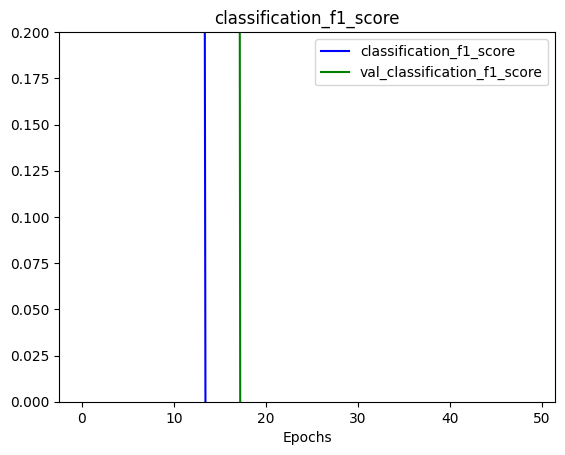

In [43]:
plot_metrics("loss", "val_loss", ylim=0.2)
plot_metrics("classification_f1_score", "classification_f1_score", ylim=0.2)

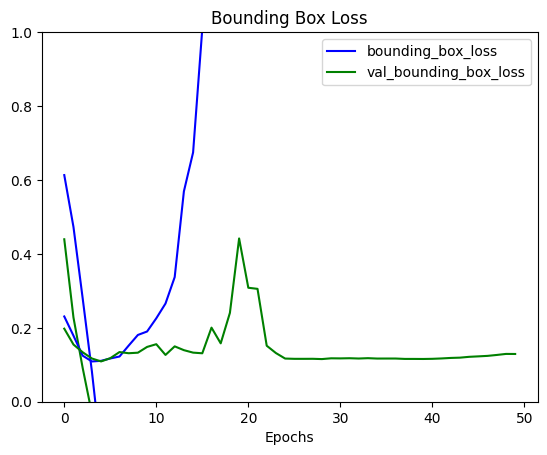

In [44]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")